# Example 8: RVT SRA with simulated profiles

Use RVT with simulated profiles to compute the surface response spectrum and surface spectral ratio.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Create a point source theory RVT motion

In [3]:
m = pysra.motion.SourceTheoryRvtMotion(6.0, 30, 'wna')
m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=100), 10, 400),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200), 10, 450),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=400), 30, 600),
    pysra.site.Layer(
        pysra.site.SoilType('Rock', 24., None, 0.01), 0, 1200),
])

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.ToroVelocityVariation.generic_model(
    'USGS C')
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.InitialVelProfile(),
])

## Perform the calculation

In [8]:
count = 20
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity,
        var_soiltypes=var_soiltypes
):
    # Here we auto-descretize the profile for wave propagation purposes
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

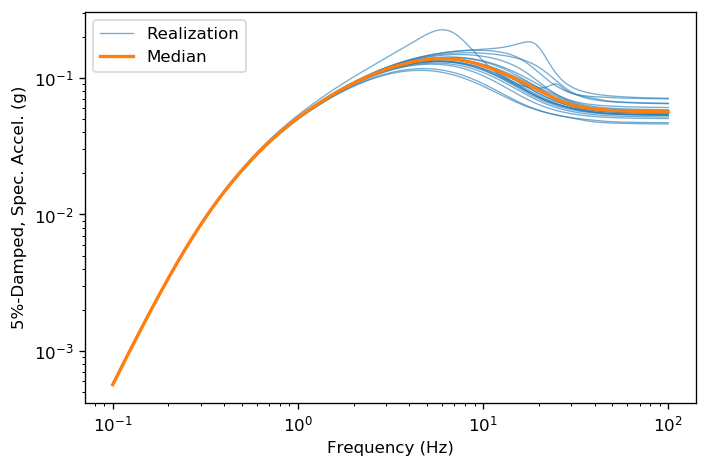

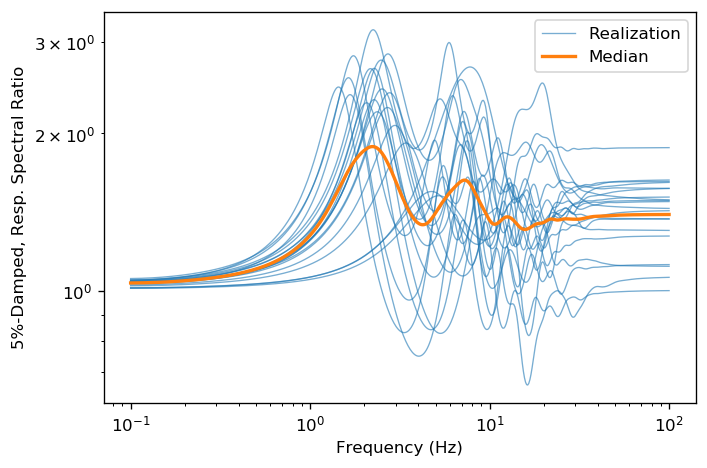

In [9]:
for o in outputs[:-1]:
    ax = o.plot()

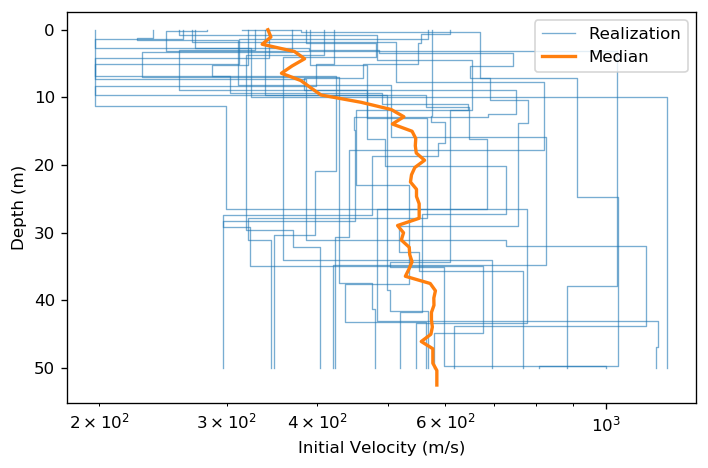

In [10]:
ax = outputs[-1].plot()

The statistics of the output can be also retrieved and returned as either a `dict` or `pandas.DataFrame`.

In [11]:
outputs[-1].calc_stats()

{'ref': array([ 0.        ,  1.07142857,  2.14285714,  3.21428571,  4.28571429,
         5.35714286,  6.42857143,  7.5       ,  8.57142857,  9.64285714,
        10.71428571, 11.78571429, 12.85714286, 13.92857143, 15.        ,
        16.07142857, 17.14285714, 18.21428571, 19.28571429, 20.35714286,
        21.42857143, 22.5       , 23.57142857, 24.64285714, 25.71428571,
        26.78571429, 27.85714286, 28.92857143, 30.        , 31.07142857,
        32.14285714, 33.21428571, 34.28571429, 35.35714286, 36.42857143,
        37.5       , 38.57142857, 39.64285714, 40.71428571, 41.78571429,
        42.85714286, 43.92857143, 45.        , 46.07142857, 47.14285714,
        48.21428571, 49.28571429, 50.35714286, 51.42857143, 52.5       ]),
 'median': array([341.92795882, 345.15532512, 335.74172497, 371.97407844,
        384.12650258, 369.05783288, 356.86222431, 379.47836278,
        391.64508875, 404.70727748, 459.20490711, 505.50759673,
        526.34040282, 507.41737248, 540.15821154, 546.50195

In [12]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,341.927959,0.293323
1.071429,345.155325,0.293571
2.142857,335.741725,0.312757
3.214286,371.974078,0.308261
4.285714,384.126503,0.309105
5.357143,369.057833,0.341949
6.428571,356.862224,0.383747
7.500000,379.478363,0.454462
8.571429,391.645089,0.426091


## Repeat using a Generic Depth-Dependent Model

The generic `DepthDependToroVelVariation` follows the SPID guidance.

In [13]:
var_velocity_dd = pysra.variation\
    .DepthDependToroVelVariation.generic_model('USGS C')

In [14]:
outputs.reset()
count = 20
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity_dd,
        var_soiltypes=var_soiltypes
):
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

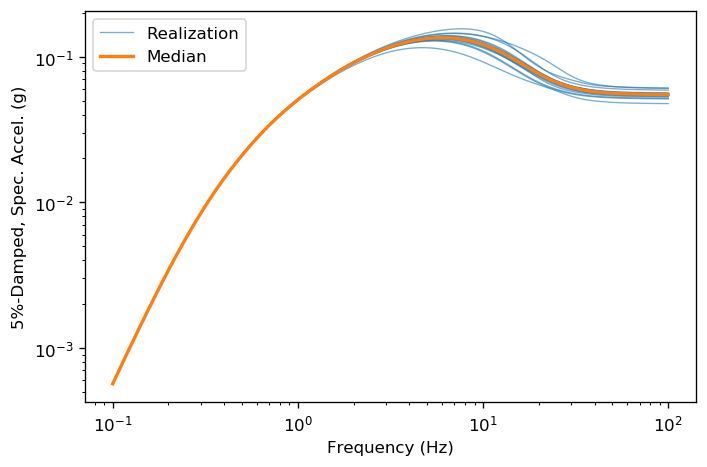

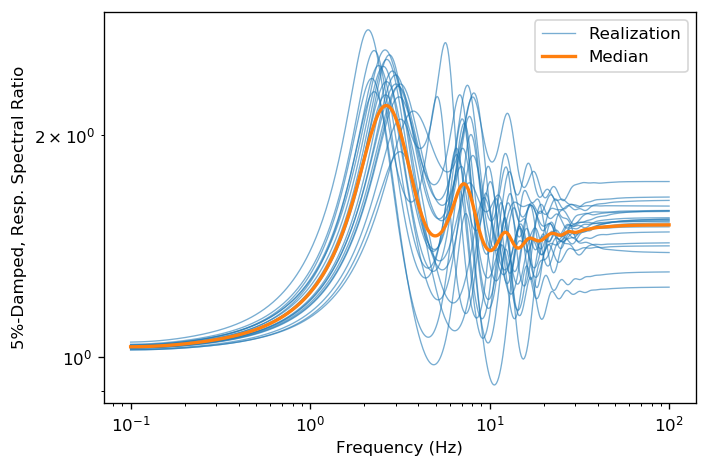

In [16]:
for o in outputs[:-1]:
    ax = o.plot()

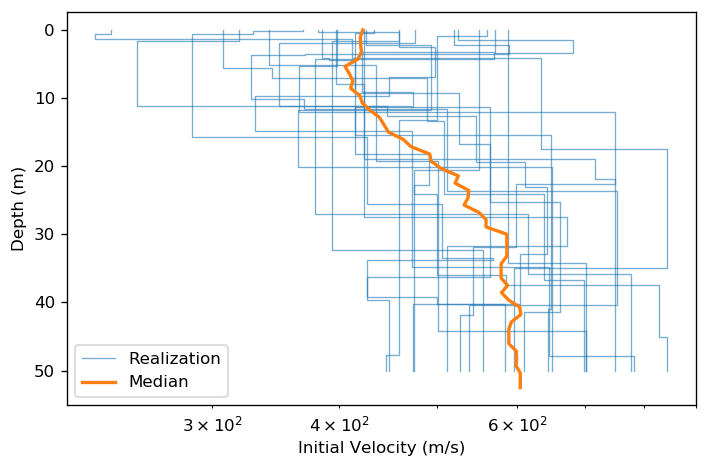

In [17]:
ax = outputs[-1].plot()

In [18]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,422.370205,0.229998
1.071429,419.970065,0.234671
2.142857,420.199057,0.247780
3.214286,421.120618,0.222370
4.285714,417.804182,0.245715
5.357143,405.700825,0.222702
6.428571,409.681014,0.226835
7.500000,412.960980,0.224731
8.571429,410.816812,0.221556


## Repeat using a Specific Depth-Dependent Model

In [19]:
var_velocity_dd = pysra.variation\
    .DepthDependToroVelVariation.generic_model(
    'USGS C',
    depth=[0, 10, 20],
    ln_std=[0.25, 0.15, 0.10]
)

In [20]:
outputs.reset()
count = 20
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity_dd,
        var_soiltypes=var_soiltypes
):
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

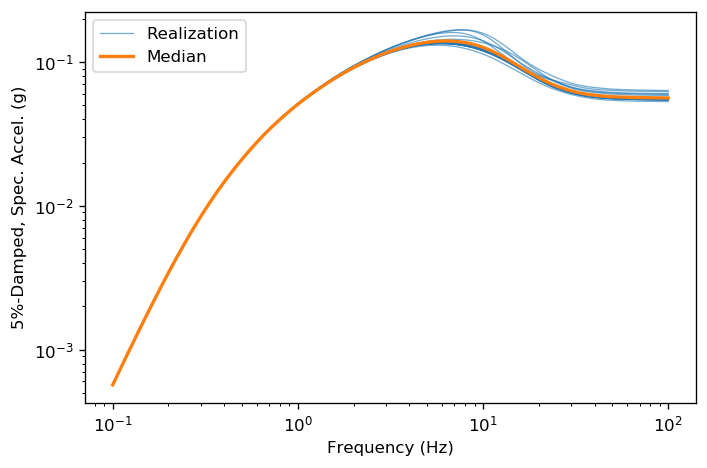

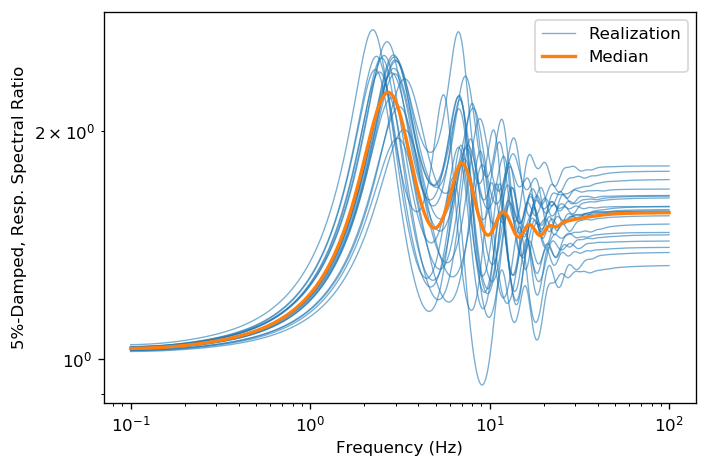

In [21]:
for o in outputs[:-1]:
    ax = o.plot()

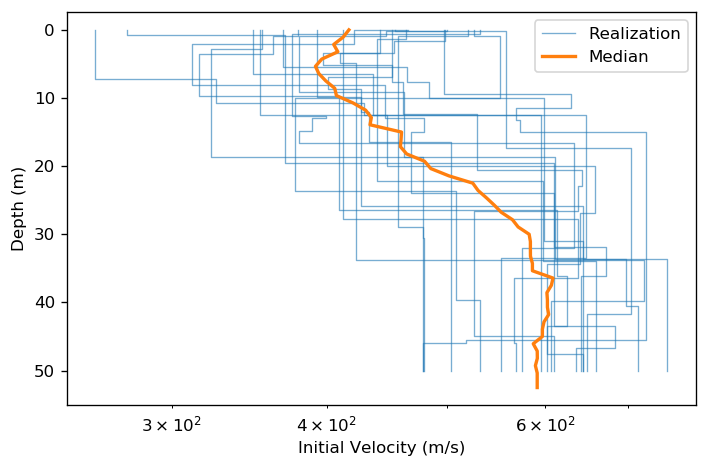

In [22]:
ax = outputs[-1].plot()

In [23]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,416.886212,0.200420
1.071429,412.413620,0.194952
2.142857,405.269126,0.186917
3.214286,408.418366,0.176027
4.285714,396.413427,0.183916
5.357143,391.755701,0.187124
6.428571,394.277526,0.189685
7.500000,399.433786,0.192541
8.571429,406.060396,0.168518
